# Predicting Price of Airbnb Listings in NYC - Part 2

With data cleaning and feature engineering complete, it is time now to apply machine learning algorithms to develop an approprie price prediction model and derive futher insights from the data.

In [1]:
#import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.tree            import DecisionTreeRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#read the cleaned data from a file:
df = pd.read_csv("processed_df_airbnb.csv")
target = df['log_price'].copy()
#drop unnecessary columns
df = df.drop(['Unnamed: 0','log_price'], axis=1).copy()
#strip the target column from input columns and put it in front
df = pd.concat([target, df], axis=1).copy()
#select input variable columns
nums = df.iloc[:,1:]

Let's first review the final dataframe that will be used for the analysis:

In [3]:
#first few rows of the dataframe:
df.head()

,log_price,latitude,longitude,log_(minimum_nights +1),log_(number_of_reviews +1),log_(reviews_per_month +1),log_(calculated_host_listings_count +1),log_(availability_365 +1),Allerton,Arden Heights,...,guest,comfortable,lady,girl,amazing,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,5.003946,40.64749,-73.97237,0.693147,2.302585,0.190620,1.945910,5.902633,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4.488636,40.66829,-73.98779,1.609438,5.123964,0.850151,1.386294,5.752573,0,0,...,0,0,0,0,0,0,1,0,0,0
2,4.867534,40.68069,-73.97706,1.098612,4.875197,0.737164,1.945910,5.852202,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.382027,40.67989,-73.97798,0.693147,3.688879,0.314811,1.945910,5.899897,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4.700480,40.68001,-73.97865,1.098612,4.276666,0.476234,1.945910,5.720312,0,0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
#dataframe shape
print(df.shape)

(48026, 321)


In [5]:
#column names in the dataframe
df.columns.tolist()

['log_price',
 'latitude',
 'longitude',
 'log_(minimum_nights +1)',
 'log_(number_of_reviews +1)',
 'log_(reviews_per_month +1)',
 'log_(calculated_host_listings_count +1)',
 'log_(availability_365 +1)',
 'Allerton',
 'Arden Heights',
 'Arrochar',
 'Arverne',
 'Astoria',
 'Bath Beach',
 'Battery Park City',
 'Bay Ridge',
 'Bay Terrace',
 'Bay Terrace, Staten Island',
 'Baychester',
 'Bayside',
 'Bayswater',
 'Bedford-Stuyvesant',
 'Belle Harbor',
 'Bellerose',
 'Belmont',
 'Bensonhurst',
 'Bergen Beach',
 'Boerum Hill',
 'Borough Park',
 'Breezy Point',
 'Briarwood',
 'Brighton Beach',
 'Bronxdale',
 'Brooklyn Heights',
 'Brownsville',
 "Bull's Head",
 'Bushwick',
 'Cambria Heights',
 'Canarsie',
 'Carroll Gardens',
 'Castle Hill',
 'Castleton Corners',
 'Chelsea',
 'Chinatown',
 'City Island',
 'Civic Center',
 'Claremont Village',
 'Clason Point',
 'Clifton',
 'Clinton Hill',
 'Co-op City',
 'Cobble Hill',
 'College Point',
 'Columbia St',
 'Concord',
 'Concourse',
 'Concourse Villa

With one hot encoding, feature engineering and natural language processing the shape of the dataframe grew substantially. 
- Several numeric columns have been log transformed
- Individual neighborhoods have been one hot encoded along with boroughs and categorized times since the last review
- Lastly columns were created to document use of popular words in the listing name


Next, let's use the entire dataset and feed it into some of the most common regression models to see what sort of root mean square error we get:

## Experiment with several ML approaches

In [6]:
y= target
x = nums
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

### Decision Tree Regression - kfold

In [7]:
rmse_dt=[]
dt = DecisionTreeRegressor()
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(dt ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_dt.append(avg_rmse)
print("Root mean square error: " +str(round(rmse_dt[0],2)))

Root mean square error: 0.53


### XG Boost - kfold

In [8]:
rmse_xg = []
data_dmatrix = xgb.DMatrix(data=x,label=y)
params = {
              'colsample_bytree': 0.9,
              'learning_rate': 0.1,
              'max_depth': 1, 
              'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=300,
                        early_stopping_rounds=10, metrics="rmse", as_pandas=True, 
                        seed=123)
    
rmse_xg.append(cv_results["test-rmse-mean"].tolist()[-1])
print("Root mean square error: " +str(round(rmse_xg[0],2)))

[17:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

### Random Forest Regression - kfold

In [9]:
rmse_rf=[]
rf=RandomForestRegressor(n_estimators = 100, random_state=1,  min_samples_leaf=2)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(rf ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_rf.append(avg_rmse)
print(rmse_rf)

[0.37843357631989427]


### Neural Network  - kfold

In [10]:
rmse_nndf=[]
mlp = MLPRegressor(activation='relu', max_iter=1000)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(mlp ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_nndf.append(avg_rmse)
print(rmse_nndf)

[0.3985405113331105]


In [11]:
dt = pd.Series(rmse_dt, name ="Decision Tree")
rand = pd.Series(rmse_rf, name ="Random Forest")
xgb = pd.Series(rmse_xg, name ="XG Boost")
nn = pd.Series(rmse_nndf, name="Neural Network")
pd.concat([dt,rand,xgb,nn],axis=1)

,Decision Tree,Random Forest,XG Boost,Neural Network
0,0.531263,0.378434,0.406601,0.398541


### Comments:

Random Forest model yields the lowest RMSE, followed by Neural Netork, XGBoost and Decision Tree

Since random forest yielded the best performance, let's keep optimizing it:

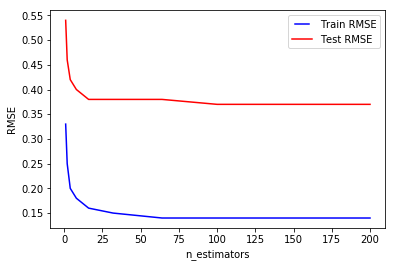

In [12]:
#optimizing number of estimators
train_results = []
test_results = []
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),2)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    test_results.append(rmse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train RMSE')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show()

- Clearly, the model overfits since the RMSE for train dataset is much lower then the test dataset regardless of the number of estimators
- For the best model performance on unseen data, a minimum of 100 estimators appears to be sufficient

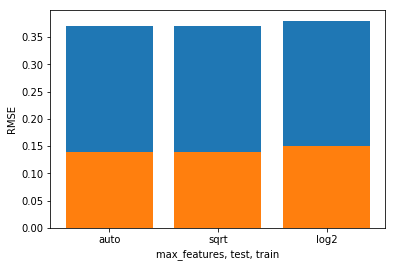

In [13]:
#optimizing max_features
train_results = []
test_results = []
max_features = ['auto','sqrt','log2']
for feature in max_features:
    rf = RandomForestRegressor(max_features=feature, n_estimators=100, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),2)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    test_results.append(rmse)
    
plt.bar(max_features,test_results)
plt.bar(max_features,train_results)
plt.ylabel('RMSE')
plt.xlabel('max_features, test, train')
plt.show()

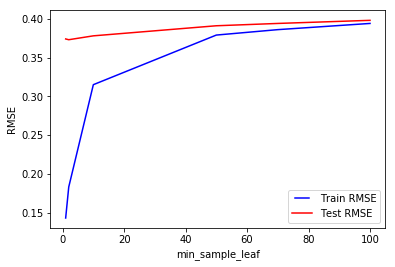

In [14]:
#optimizing min_sample_leaf
train_results = []
test_results = []
min_samples_leaf = [1,2,10,50,70,100]
for leaf in min_samples_leaf:
    rf = RandomForestRegressor(min_samples_leaf = leaf, max_features='auto', n_estimators=100, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),3)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    test_results.append(rmse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leaf, train_results, 'b', label='Train RMSE')
line2, = plt.plot(min_samples_leaf, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('min_sample_leaf')
plt.show()

In [15]:
test_results 

[0.374, 0.373, 0.378, 0.391, 0.394, 0.398]

The graph above inticates that the model provides the best performance if the minimum samples on a leaf is at least 1

Based on the hyperparameter optimization the best hyperparameter conditions are:
- n_estimator = 100
- max_features = 'auto'
- min_samples_leaf = 2

Next, apply these parameters to see how the overall model performs:

In [16]:
#apply the hyperparameter optmized model:
rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=2, random_state=1)
rf.fit(X_train,y_train)
predicted = rf.predict(X_test)

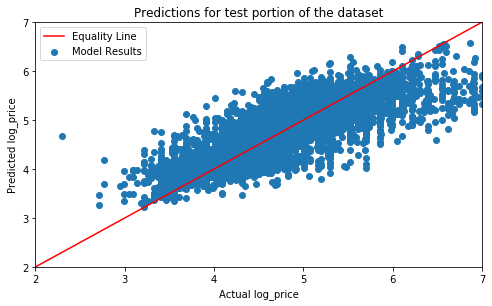

In [17]:
#plot the results of the model:
plt.figure(figsize=(8,4.5))
plt.scatter(y_test,predicted, label="Model Results")
plt.plot([2,7],[2,7], color="red", label = "Equality Line")
plt.title("Predictions for test portion of the dataset")
plt.xlim(2,7)
plt.ylim(2,7)
plt.legend()
plt.ylabel("Predicted log_price")
plt.xlabel("Actual log_price")
plt.show()

In [18]:
print("Model accuracy measures for withheld data:\nR2: "+str(round(r2_score(y_test,predicted),2)))
print("Root mean square error: "+str(round(np.sqrt(mean_squared_error(y_test,predicted)),3)))

Model accuracy measures for withheld data:
R2: 0.69
Root mean square error: 0.372


### Comments:

On the low end of the actual log_price the results tend to cluster above the line, while on the high end they tend to cluster below the line. 

This has consequences of underpredicting high prices and overpredicting low prices.

Next, let's take a look at what features are important in the model:

In [19]:
#derive important features
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Number of important features: "+str(feature_importances[feature_importances["importance"]!=0].shape[0]))
print("\nTop fifteen features by importance:")
feature_importances[feature_importances["importance"]!=0].head(15)

Number of important features: 300

Top fifteen features by importance:


,importance
Entire home/apt,0.442622
longitude,0.107504
latitude,0.098819
log_(availability_365 +1),0.053278
Manhattan,0.035903
log_(reviews_per_month +1),0.032822
log_(minimum_nights +1),0.031873
log_(number_of_reviews +1),0.027910
log_(calculated_host_listings_count +1),0.017980
studio,0.015366


The most important features that factor into the price of a listing are:

- listing type (if it is a home/apartment)
- location, which is very intuitive considering that in real estate location is often a decided factor for price
- availability and review related factors
- certain listing descriptor words indicating the character or location of a listing

### Further visualization of results

The three graphs below illustrate the pricing in USD:
- first graph illustrates actual and predicted price for the test dataset in order of growing price
- second graph illustrates associated % error
- finally the third graph visualizes the distribution of errors with respect to latitude and longitude

In [20]:
predicted_ = rf.predict(X_test)
pred = pd.DataFrame({'Predicted log_price':predicted_,'log_price':y_test})
df_with_predictions = pd.concat([X_test, pred], axis=1).copy()
df_with_predictions["price"]=df_with_predictions["log_price"].apply(lambda x: np.exp(x))
df_with_predictions["predicted_price"]=df_with_predictions["Predicted log_price"].apply(lambda x: round(np.exp(x),1))

In [21]:
prices=df_with_predictions.sort_values(by="price").reset_index()
prices["error"]=np.abs(prices.price-prices.predicted_price)/prices.price*100

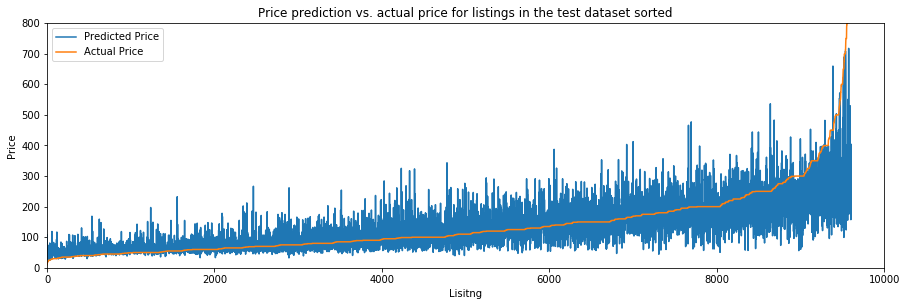

In [22]:
plt.figure(figsize=(15,4.5))
plt.plot(prices["predicted_price"], label="Predicted Price")
plt.plot(prices["price"], label = "Actual Price")
plt.title("Price prediction vs. actual price for listings in the test dataset sorted")
plt.xlim(0,10000)
plt.ylim(0,800)
plt.legend()
plt.ylabel("Price USD")
plt.xlabel("Lisitng")
plt.show()


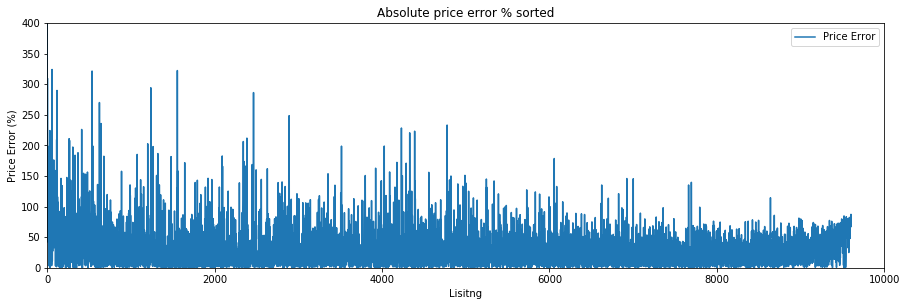

In [23]:
plt.figure(figsize=(15,4.5))
plt.plot(prices["error"], label="Price Error")
plt.title("Absolute price error % sorted")
plt.xlim(0,10000)
plt.ylim(0,400)
plt.legend()
plt.ylabel("Price Error (%)")
plt.xlabel("Lisitng")
plt.show()

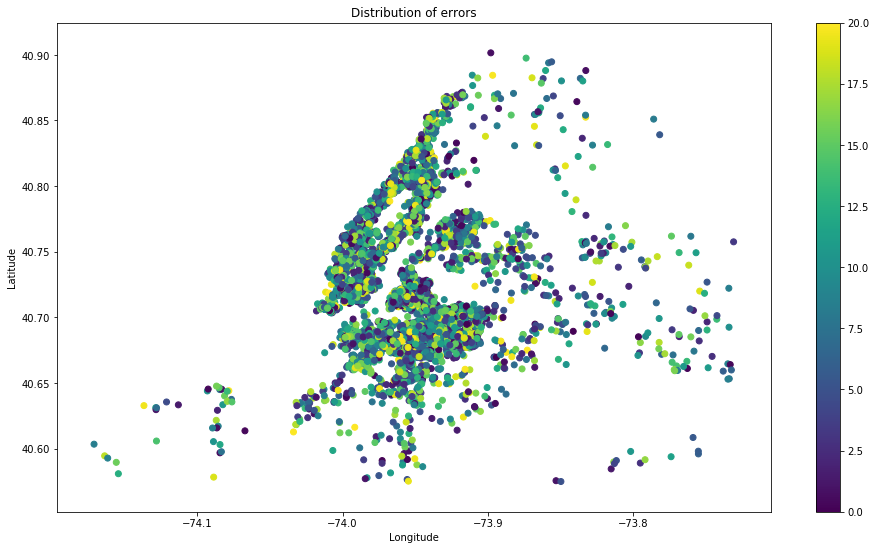

In [24]:
small_error = prices[prices.error<20].copy()
y = small_error["latitude"]
x = small_error["longitude"]
p = small_error.error
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p,cmap='viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of errors")
plt.show()

There is no apparent geographic concentration of error visible in the graph above.


The following are mean price errors for each borough in USD.

In [25]:
print(prices[prices.Manhattan==1]["error"].mean())
print(prices[prices.Brooklyn==1]["error"].mean())
print(prices[prices.Bronx==1]["error"].mean())
print(prices[prices.Queens==1]["error"].mean())
print(prices[prices["Staten Island"]==1]["error"].mean())

29.369317672969512
27.73005158133444
36.93683823546799
27.701474581228034
29.4801137369953


### Impact of Private v. Shared v. Home on the model's accuracy

Let's look at model efficiency differences when considering different listing types (shared, private, apartment):

In [26]:
#define random forest function with kfold cross-validation
def random_forest(df):
    target = df['log_price'].copy()
    #select input variable columns
    nums = df.iloc[:,1:]

    #split the data into test and train
    y= target
    x = nums
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

    rmse_rf=[]
    rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=1, random_state=1)
    kf = KFold(5, shuffle = True, random_state=1)
    mse = cross_val_score(rf ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
    rmse = np.sqrt(np.absolute(mse))
    avg_rmse = np.sum(rmse)/len(rmse)
    rmse_rf.append(avg_rmse)
    return rmse_rf

In [27]:
#separate datasets
private = df[df["Private room"]==1].copy()
shared = df[df["Shared room"]==1].copy()
homes = df[df["Entire home/apt"]==1].copy()

private_rmse = random_forest(private)
shared_rmse = random_forest(shared)
home_rmse = random_forest(homes)

print("\nShared RMSE: "+str(round(shared_rmse[0],3)))
print("Private RMSE: "+str(round(private_rmse[0],3)))
print("Home RMSE: "+str(round(home_rmse[0],3)))


Shared RMSE: 0.437
Private RMSE: 0.34
Home RMSE: 0.405


- Private room dataset yielded the best model accuracy followed by home and shared. 
- The difference in accuracy between shared and the other two datasets is most likely derived from fewer datapoints available to train the shared model, resulting in lower accuracy.
- It is clear that the model predicts with better accuracy for private listings than for the home/apartment listings. It is likely driven by larger spread of prices within the home/apartments listings relative to private listings. Look at standard deviations for the two population samples below:

In [28]:
print(private.log_price.std())
print(homes.log_price.std())

0.46758340899829653
0.5273688688485029


### Impact of Borough on the model's accuracy

In [29]:
#separate datasets
manhattan = df[(df["Manhattan"]==1)].copy()
brooklyn = df[(df["Brooklyn"]==1)].copy()
queens = df[(df["Queens"]==1)].copy()
bronx = df[(df["Bronx"]==1)].copy()
staten_island = df[(df["Staten Island"]==1)].copy()

manhattan_rmse = random_forest(manhattan)
brooklyn_rmse = random_forest(brooklyn)
queens_rmse = random_forest(queens)
bronx_rmse = random_forest(bronx)
staten_island_rmse = random_forest(staten_island)

print("\nManhattan RMSE: "+str(round(manhattan_rmse[0],3)))
print("Brooklyn RMSE: "+str(round(brooklyn_rmse[0],3)))
print("Queens RMSE: "+str(round(queens_rmse[0],3)))
print("Bronx RMSE: "+str(round(bronx_rmse[0],3)))
print("Staten Island RMSE: "+str(round(staten_island_rmse[0],3)))


Manhattan RMSE: 0.384
Brooklyn RMSE: 0.369
Queens RMSE: 0.369
Bronx RMSE: 0.419
Staten Island RMSE: 0.458


In [30]:
print("Number of listings in Manhattan: "+str(len(manhattan)))
print("Number of listings in Brooklyn: "+str(len(brooklyn)))
print("Number of listings in Queens: "+str(len(queens)))
print("Number of listings in Bronx: "+str(len(bronx)))
print("Number of listings in Staten Island: "+str(len(staten_island)))

Number of listings in Manhattan: 21192
Number of listings in Brooklyn: 19801
Number of listings in Queens: 5592
Number of listings in Bronx: 1071
Number of listings in Staten Island: 370


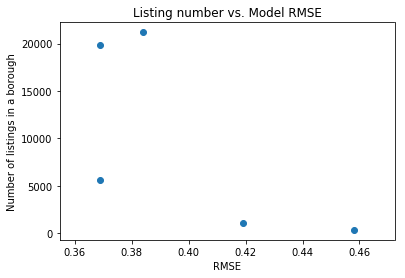

In [31]:
plt.scatter(x=[0.384,0.369,0.369,0.419,0.458],y=[21192,19801,5592,1071,370])
plt.xlabel("RMSE")
plt.ylabel("Number of listings in a borough")
plt.title("Listing number vs. Model RMSE")
plt.show()

There are also large differences in model performance from borough to borough. The graph above illustrates that as the number of listings in a given borough decreases, the model accuracy decreases as well. The only exception is Queens where in spite of a realtively small amount of listings, the model delivered a very good performance.

As a next step let's check model accuracy for each borough considering only private rooms.

In [32]:
#separate datasets
manhattan = df[(df["Manhattan"]==1)&(df["Private room"]==1)].copy()
brooklyn = df[(df["Brooklyn"]==1)&(df["Private room"]==1)].copy()
queens = df[(df["Queens"]==1)&(df["Private room"]==1)].copy()
bronx = df[(df["Bronx"]==1)&(df["Private room"]==1)].copy()
staten_island = df[(df["Staten Island"]==1)&(df["Private room"]==1)].copy()

manhattan_rmse = random_forest(manhattan)
brooklyn_rmse = random_forest(brooklyn)
queens_rmse = random_forest(queens)
bronx_rmse = random_forest(bronx)
staten_island_rmse = random_forest(staten_island)

print("\nManhattan RMSE: "+str(round(manhattan_rmse[0],3)))
print("Brooklyn RMSE: "+str(round(brooklyn_rmse[0],3)))
print("Queens RMSE: "+str(round(queens_rmse[0],3)))
print("Bronx RMSE: "+str(round(bronx_rmse[0],3)))
print("Staten Island RMSE: "+str(round(staten_island_rmse[0],3)))


Manhattan RMSE: 0.359
Brooklyn RMSE: 0.33
Queens RMSE: 0.325
Bronx RMSE: 0.374
Staten Island RMSE: 0.366


Here see if the global model and deliver the same performance as the specialized model for the same set of data. For instance only Manhattand and only private room.

In [33]:
#read the cleaned data from a file:
df = pd.read_csv("processed_df_airbnb.csv")
target = df['log_price'].copy()
#drop unnecessary columns
df = df.drop(['Unnamed: 0','log_price'], axis=1).copy()
#strip the target column from input columns and put it in front
df = pd.concat([target, df], axis=1).copy()
#select input variable columns
nums = df.iloc[:,1:]

In [45]:
# RMSE for the global model considering Queens and Private room only
qns_priv_price=df_with_predictions[(df_with_predictions["Queens"]==1)&(df_with_predictions["Private room"]==1)].log_price
qns_priv_predprice=df_with_predictions[(df_with_predictions["Queens"]==1)&(df_with_predictions["Private room"]==1)]["Predicted log_price"]
rmse_global = round(np.sqrt(mean_squared_error(qns_priv_price, qns_priv_predprice)),3)
print(rmse_global)

0.334


In [48]:
#separating the data to make it specific to the borough of Queens and the listing type
df=df[(df["Queens"]==1)&(df["Private room"]==1)].copy()

target = df['log_price'].copy()
#drop unnecessary columns
df = df.drop(['log_price'], axis=1).copy()
#strip the target column from input columns and put it in front
df = pd.concat([target, df], axis=1).copy()
#select input variable columns
nums = df.iloc[:,1:]

y= target
x = nums
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=2, random_state=1)
rf.fit(X_train,y_train)
predicted = rf.predict(X_test)

In [49]:
round(np.sqrt(mean_squared_error(y_test, predicted)),3)

0.309

Based on the Queens/Private bedroom example it appears to be more beneficial to train several models specific to the listing type and location (such as Borough).

Making a model specific improved RMSE from 0.334 to 0.309 or by 7.5%.

Let's see if taking the approach of using a model specifc to borough and listing type can improve the overall RMSE for the entire data set.

In [81]:
def final_model(borough, room_type):
    '''Build a function specifc to a borough and room_type'''
    #read the cleaned data from a file:
    df = pd.read_csv("processed_df_airbnb.csv")
    #filter the data
    df=df[(df[borough]==1)&(df[room_type]==1)].copy()    
    target = df['log_price'].copy()
    #drop unnecessary columns
    df = df.drop(['Unnamed: 0','log_price'], axis=1).copy()    
    #strip the target column from input columns and put it in front
    df = pd.concat([target, df], axis=1).copy()
    #select input variable columns
    nums = df.iloc[:,1:]
    
    y= target
    x = nums
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

    rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=2, random_state=1)
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)
    y_test = y_test.values.tolist()
    predicted = predicted.tolist()
    return y_test, predicted 

Run individual models and combine the predictions

In [87]:
boroughs = ["Manhattan", "Brooklyn", "Bronx","Queens","Staten Island"]
listings= ["Private room","Shared room","Entire home/apt"]

In [106]:
actual=[]
predicted=[]
for borough in boroughs:
    for listing in listings:
        a,b = final_model(borough, listing)
        actual +=a
        predicted +=b

In [101]:
round(np.sqrt(mean_squared_error(actual, predicted)),3)

0.378

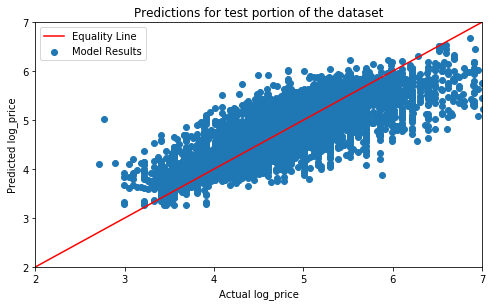

In [113]:
#plot the results of the model:
plt.figure(figsize=(8,4.5))
plt.scatter(actual, predicted, label="Model Results")
plt.plot([2,7],[2,7], color="red", label = "Equality Line")
plt.title("Predictions for test portion of the dataset")
plt.xlim(2,7)
plt.ylim(2,7)
plt.legend()
plt.ylabel("Predicted log_price")
plt.xlabel("Actual log_price")
plt.show()

In [116]:
print("Model accuracy measures for withheld data:\nR2: "+str(round(r2_score(actual,predicted),3)))
print("Root mean square error: "+str(round(np.sqrt(mean_squared_error(actual,predicted)),3)))

Model accuracy measures for withheld data:
R2: 0.679
Root mean square error: 0.378


While the approach of building individual models worked well for certain cases, overall the RMSE of 0.378 was higher than the one achieved using the entire dataset (0.372)

### In summary:

- Random Forest regression model provided best accuracy for prediction of listing price based on variables generated from the initial data
- the model as is tends to underpredict listings priced relatively high
- the model tends to underpredict listings priced relatively low
- the model importances can be used to further understand what drives the price of an Airbnb listing in NYC
- RMSE are given based on log_price values